In [59]:
"""
auteur:Alexandre
date:2024/09/04

Développement d'un autoencodeur pour analyser les possibles bureaux de votes uniques
"""

"\nauteur:Alexandre\ndate:2024/09/04\n\nDéveloppement d'un autoencodeur pour analyser les possibles bureaux de votes uniques\n"

# **Autres méthodes de Machine Learning**

## Chargement des données

In [60]:
import pandas as pd
import params as prm
import preprocessing as pp
import os

In [61]:
df_1f = pd.read_csv(os.path.join(prm.datasets_path, f"DF_{prm.dataset_1er_tour}.csv"))
df_2f = pd.read_csv(os.path.join(prm.datasets_path, f"DF_{prm.dataset_2nd_tour}.csv"))

In [62]:
data_1 = pp.load_data(file_name=f"{prm.dataset_1er_tour}.csv")
data_2 = pp.load_data(file_name=f"{prm.dataset_2nd_tour}.csv")

In [63]:
AE_df, dico = pp.clarifiation(df=data_1)

c:\Users\alexa\Documents\PYTHON\Pipeline_Elections_Legislatives\main\preprocessing.py:237: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_4 = df_3.replace({


## Création du modèle

In [64]:
import torch

In [65]:
class AutoEncodeur(torch.nn.Module):
    def __init__(self, N_1er):
        super(AutoEncodeur, self).__init__()

        self.encodeur = torch.nn.Sequential(
            torch.nn.Linear(N_1er, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 3),
        )

        self.decodeur = torch.nn.Sequential(
            torch.nn.Linear(3, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, N_1er),
        )

    def forward(self, x):

        encoded = self.encodeur(x)
        decoded = self.decodeur(encoded)

        return decoded

## Fonction d'apprentissage

In [66]:
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [67]:
def fit_data(
    df_1f,
    df_2f,
    
    lr=1e-6,
    batch_size=64,
    num_epochs=500,
    
    seed=2022,
    device="cuda"
):
    # Paramètrage des calculs
    if device == "cpu":
        print(f"Il semble y avoir {os.cpu_count()} coeurs dans cet ordi !")
    elif device == "cuda":
        if torch.cuda.is_available() == True:
            print("GPU ! GPU ! GPU !")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda": torch.cuda.empty_cache()

    # Preparation des données
    X_train, X_test, Y_train, Y_test = train_test_split(
        df_1f, df_2f, 
        test_size=.2, 
        random_state=seed, 
        shuffle=True
    )
    loader = DataLoader(
                    TensorDataset(
                        torch.Tensor(X_train.to_numpy()).to(device), 
                        torch.Tensor(Y_train.to_numpy()).to(device)
                    ), batch_size=batch_size, shuffle=True
                )
    
    # Préparation du modèle
    N_1er, N_2eme = len(df_1f.columns), len(df_2f.columns)
    AE = AutoEncodeur(N_1er)
    AE = AE.to(device)

    # Préparation de l'apprentissage
    optimizer = torch.optim.Adam(
        AE.parameters(), 
        lr=lr
    )
    criterion = torch.nn.MSELoss()

    losses_train = []
    losses_test = []

    for epoch in tqdm(range(int(num_epochs)), desc=f"Computing on {device}"):
        
        for p_1, p_2 in loader:

            p_1, p_2 = p_1.to(device), p_2.to(device)
            
            p_1_pred = AE(p_1)

            loss_train = criterion(p_1, p_1_pred)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        losses_train.append(loss_train.cpu().detach().item())

        with torch.no_grad():
            
            X_pred = AE(torch.Tensor(X_test.to_numpy()).to(device))

            losse_test = criterion(torch.Tensor(X_test.to_numpy()).to(device),
                                    X_pred)
            losses_test.append(losse_test.cpu().detach().item())

    return AE, np.array(losses_train), np.array(losses_test), X_pred.cpu().detach().numpy(), X_test.to_numpy(),

## Entrainement du modèle

In [68]:
num_epoch = 200
batch_size = 2**5
device = "cuda"

In [69]:
# Utilsation du dataset préparer pour le transfert de voix
AE, losses_train, losses_test, pred, test = fit_data(
    df_1f=df_1f,
    df_2f=df_2f,
    batch_size=batch_size,
    num_epochs=num_epoch,
    device="cuda"
)

GPU ! GPU ! GPU !


Computing on cuda:  16%|█▌        | 31/200 [02:05<11:48,  4.19s/it]

In [ ]:
# Utilsation du dataset préparer pour le transfert de voix
AE_clr, losses_train_clr, losses_test_clr, pred_clr, test_clr = fit_data(
    df_1f=AE_df,
    df_2f=AE_df,
    batch_size=batch_size,
    num_epochs=num_epoch,
    device="cuda"
)

GPU ! GPU ! GPU !


Computing on cuda: 100%|██████████| 200/200 [14:39<00:00,  4.40s/it]


In [ ]:
# Utilsation du dataset préparer pour le transfert de voix
AE_nrm, losses_train_nrm, losses_test_nrm, pred_nrm, test_nrm = fit_data(
    df_1f=AE_df/(AE_df.max()+1),
    df_2f=AE_df,
    batch_size=batch_size,
    num_epochs=num_epoch,
    device="cuda"
)

GPU ! GPU ! GPU !


Computing on cuda: 100%|██████████| 200/200 [15:08<00:00,  4.54s/it]


## Représentation graphique des résultats

In [ ]:
import matplotlib.pyplot as plt

NameError: name 'losses_train' is not defined

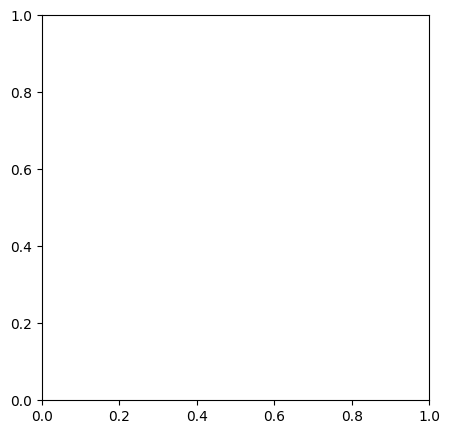

In [ ]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5)
)

ax.plot(
    losses_train,
    label="MSE loss train"
)
ax.plot(
    losses_test,
    label="MSE loss test"
)
ax.legend()

plt.tight_layout()
plt.show()

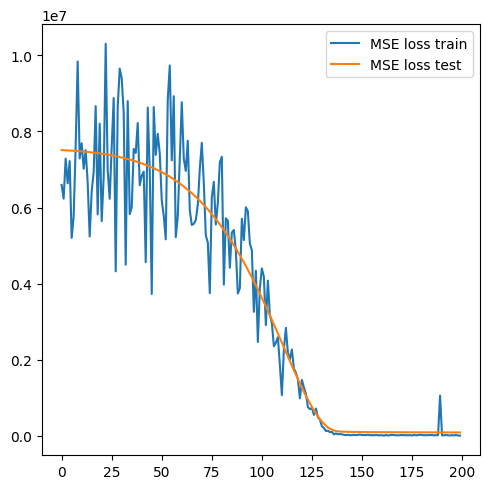

In [ ]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5)
)

ax.plot(
    losses_train_clr,
    label="MSE loss train"
)
ax.plot(
    losses_test_clr,
    label="MSE loss test"
)
ax.legend()

plt.tight_layout()
plt.show()

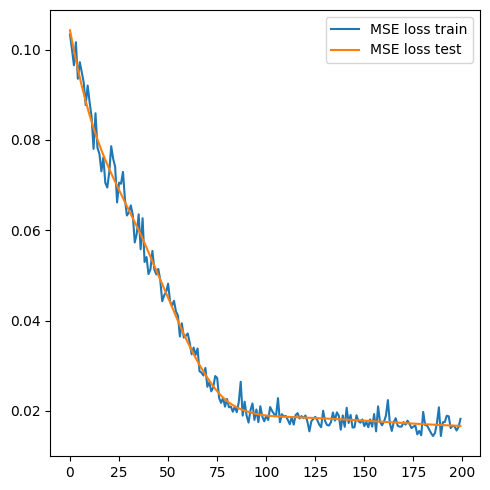

In [ ]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5)
)

ax.plot(
    losses_train_nrm,
    label="MSE loss train"
)
ax.plot(
    losses_test_nrm,
    label="MSE loss test"
)
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'AE' is not defined

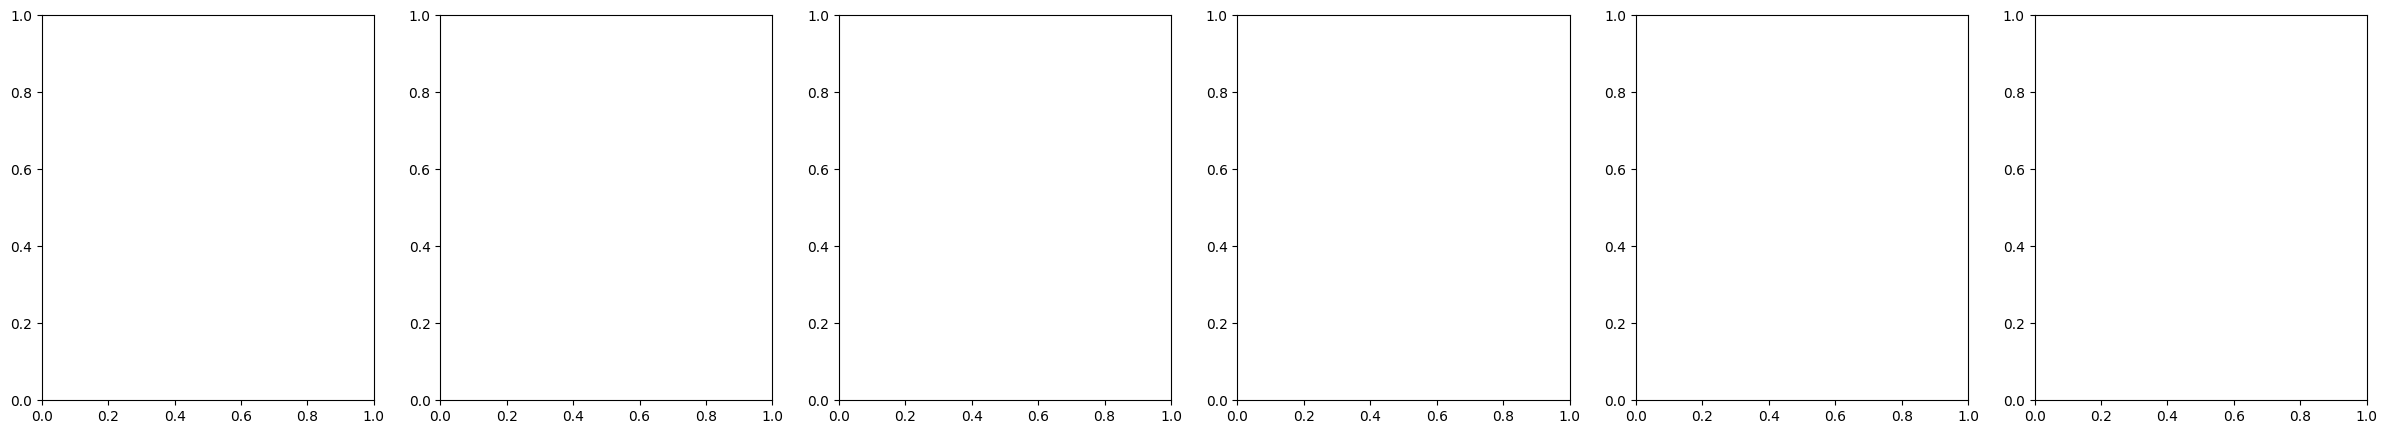

In [ ]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=6,
    figsize=(30,5)
)

for i,l in enumerate([0,2,4]):

    ax[i].imshow(
        AE.encodeur[l].weight.cpu().detach().numpy().T,
        aspect="auto"
    )
    ax[i+3].imshow(
        AE.decodeur[l].weight.cpu().detach().numpy(),
        aspect="auto"
    )

plt.tight_layout()
plt.show()

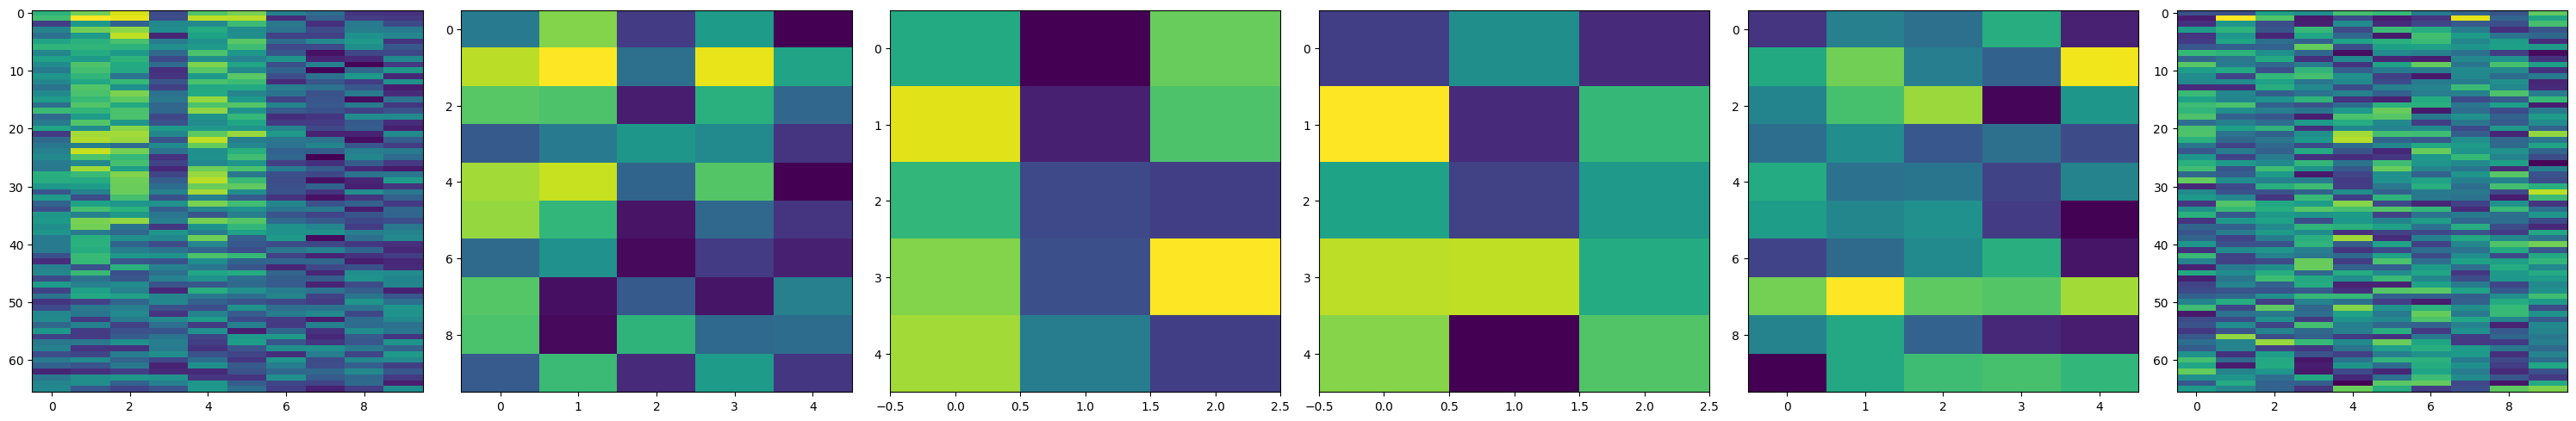

In [ ]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=6,
    figsize=(30,5)
)

for i,l in enumerate([0,2,4]):

    ax[i].imshow(
        AE_clr.encodeur[l].weight.cpu().detach().numpy().T,
        aspect="auto"
    )
    ax[i+3].imshow(
        AE_clr.decodeur[l].weight.cpu().detach().numpy(),
        aspect="auto"
    )

plt.tight_layout()
plt.show()

In [ ]:
AE_df.keys()[[1,2,4,5]]

Index(['Code commune', 'Code BV', 'Votants', 'Abstentions'], dtype='object')

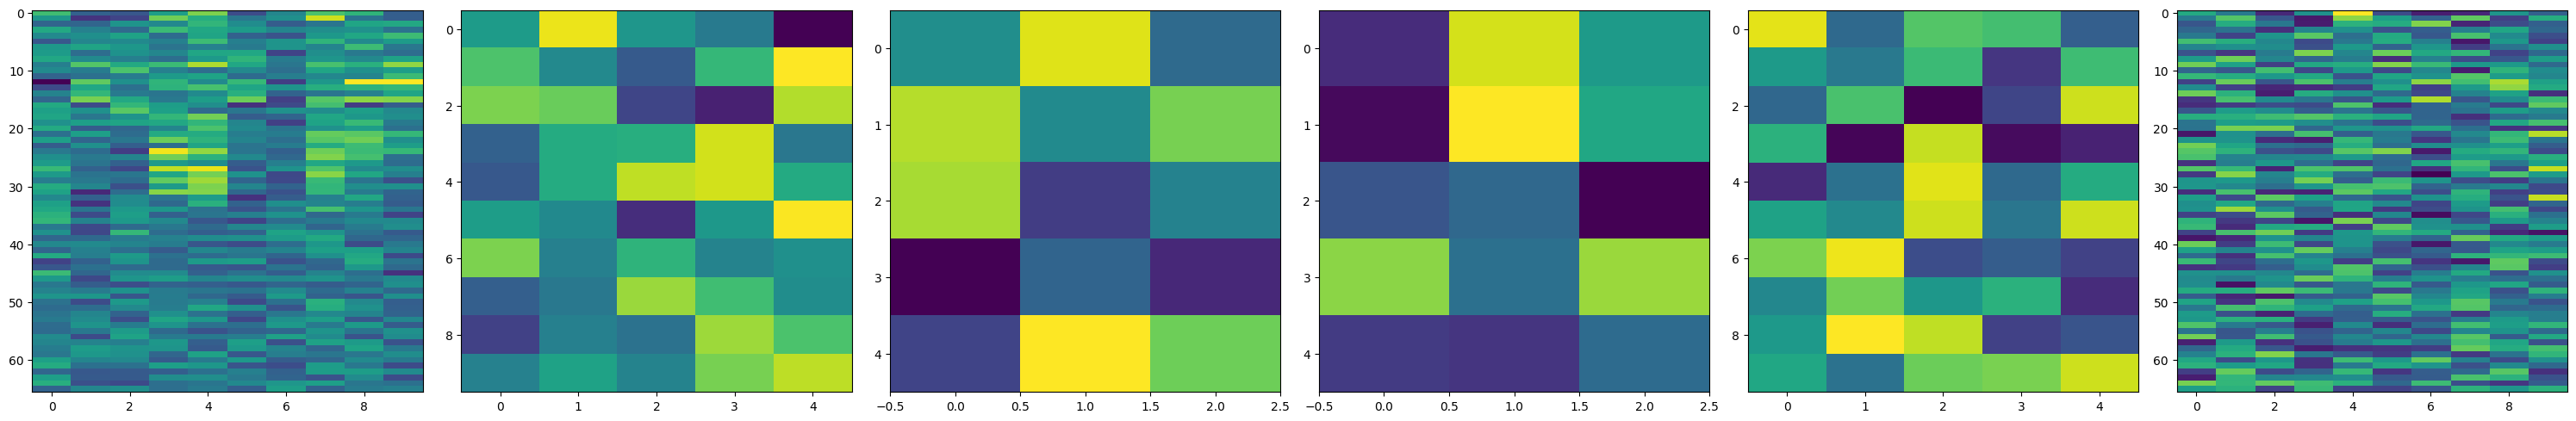

In [ ]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=6,
    figsize=(30,5)
)

for i,l in enumerate([0,2,4]):

    ax[i].imshow(
        AE_nrm.encodeur[l].weight.cpu().detach().numpy().T,
        aspect="auto"
    )
    ax[i+3].imshow(
        AE_nrm.decodeur[l].weight.cpu().detach().numpy(),
        aspect="auto"
    )

plt.tight_layout()
plt.show()